# 2020/10/16
## IBIS2020 Variable Importance Cloudの要約方法と決定木に対する実験的評価

In [1]:
import numpy as np
from sklearn import datasets
from sklearn import __version__ as sklearn_version
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import tree
import pydotplus as pdp
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
from sklearn.metrics import mean_squared_error
%matplotlib inline

## 関数 rf_
- input :
    - X : input data
    - y : output data
    - restrict : what restrict tree depth or leaf
    - num :  number of depth or leaf
    - estimators : number of trees to construct models
    - random : number of random seed

In [2]:
def rf_(X, y, restrict, num, estimators, random):
    
    if restrict == "depth":
        rf = RandomForestClassifier(n_estimators = estimators, max_depth = num, max_features=1,
                               random_state=random)
    elif restrict == "leaf":
        rf = RandomForestClassifier(n_estimators = estimators, max_leaf_nodes = num, max_features=1,
                               random_state=random)
    else:
        print("please input restrict tree by depth or leaf")
    
    rf.fit(X, y)
    
    #空のリストを作成し決定木を追加する
    DT_list = []
    
    for i in range(estimators):
        estimator = rf.estimators_[i]
        DT_list.append(estimator)
            
    return DT_list

## 関数 et_
- input :
    - X : input data
    - y : output data
    - restrict : what restrict tree depth or leaf
    - num :  number of depth or leaf
    - estimators : number of trees to construct models
    - random : number of random seed

In [3]:
def et_(X, y, restrict, num, estimators, random):
    
    if restrict == "depth":
        et = ExtraTreesClassifier(n_estimators = estimators, max_depth = num, max_features=1,
                               random_state=random)
    elif restrict == "leaf":
        et = ExtraTreesClassifier(n_estimators = estimators, max_leaf_nodes = num, max_features=1,
                               random_state=random)
    else:
        print("please input restrict tree by depth or leaf")
    
    et.fit(X, y)
    
    #空のリストを作成し決定木を追加する
    DT_list = []
    
    for i in range(estimators):
        estimator = et.estimators_[i]
        DT_list.append(estimator)
            
    return DT_list

## 関数 rashomon_set
- input : 
    * X : input data
    * y : output data
    * DT_list : list of decision tree
    * num : number of candidate of rashomon set
- output : 
    * candidate of rashomon set

In [4]:
def rashomon_set(X, y, DT_list, num):
    
    score_list = [] #決定木のスコアのリスト
    rashomon = []
        
    for i in range(len(DT_list)):
        DT = DT_list[i]
        #label = y
        #pred = DT.predict(X)
        #score = np.sqrt(mean_squared_error(label, pred))
        score = 1 - DT.score(X, y)
        #print(i, score)
        if i < num:
            rashomon.append(DT)
            score_list.append(score)
        else:
            if score < max(score_list):
                point = score_list.index(max(score_list))
                rashomon[point] = DT
                score_list[point] = score
    
    return rashomon, score_list

## 関数 VIC
 - input :
     - X : input data
     - y : output data
     - rashomon : rashomon set
     - method : method of compute feature importance
 - output :
     - VIC

In [5]:
def VIC(X, y, rashomon, method):
    
    fi = []
    if method == "gain":
        for i in range(len(rashomon)): fi.append(rashomon[i].feature_importances_)
    elif method == "per":
        for i in range(len(rashomon)):
            result = permutation_importance(rashomon[i], X, y, n_repeats=5, random_state=0)
            per_fi = result.importances_mean/sum(result.importances_mean)
            fi.append(per_fi)
            #print(sum(per_fi))
    else:
        print("please input method of compute feature importance")
        print("gain => gain or permutation importance => per")
        
    return fi

## 関数 VIC_scatter
- input : 
    - VIC : VIC list 

In [6]:
def VIC_scatter(VIC, imp, feature_name):
    
    fi_list = []
    label = []
    
    for i in range(len(VIC[0])):
        fi = []
        for j in range(len(VIC)):
            fi.append(VIC[j][i])
        fi_list.append(fi)
        label.append("X{}".format(i))
        
    if len(feature_name) != 0: label = feature_name
     
    # 箱ひげ図
    fig, ax = plt.subplots(figsize=(20, 10))
    bp = ax.boxplot(fi_list)
    ax.set_xticklabels(label)
    # タイトル名
    plt.title("box plot of {} importance for german credit dataset by random".format(imp))
    # ラベル名
    plt.xlabel("feature")
    plt.ylabel("feature importance")
    
    # 散布図行列
    df = pd.DataFrame(VIC, columns=label)

    #sns.catplot(data=df, kind='swarm')
    #plt.title("swarm plot of {} importance for monk1 dataset before one hot encoding".format(imp))
    g = sns.catplot(data=df, kind='swarm', height=10, aspect=2)
    g.set(ylim=(0.0, 0.4))
    g.fig.suptitle("swarm plot of {} importance for german credit dataset by random".format(imp),
                      y=0.95, size=24)

In [7]:
def VIC_scatter_s(VIC, start, end, imp, feature_name):
    
    fi_list = []
    label = []
    
    for i in range(len(VIC[0])):
        fi = []
        for j in range(len(VIC)):
            fi.append(VIC[j][i])
        fi_list.append(fi)
        label.append("X{}".format(i))
        
    if len(feature_name) != 0: label = feature_name
     
    # 箱ひげ図
    fig1, ax1 = plt.subplots(figsize=(20, 10))
    bp = ax1.boxplot(fi_list[start:end])
    ax1.set_xticklabels(label)
    # タイトル名
    plt.title("box plot of {} importance for german credit dataset".format(imp))
    # ラベル名
    plt.xlabel("feature")
    plt.ylabel("feature importance")
    
    # 散布図行列
    df = pd.DataFrame(VIC, columns=label)

    #sns.catplot(data=df.iloc[:, start:end], kind='swarm', height=10, aspect=2)
    #plt.title("swarm plot of {} importance for monk1 dataset before one hot encoding".format(imp))
    g = sns.catplot(data=df.iloc[:, start:end], kind='swarm', height=10, aspect=2)
    g.set(ylim=(0.0, 0.4))
    g.fig.suptitle("swarm plot of {} importance for german credit dataset".format(imp),
                      y=0.95, size=24)

## 関数 VIC_correlation
- input : 
    - VIC : VIC list 

In [8]:
def VIC_correlation(VIC, imp, feature_name):
    
    fi_list = []
    label = []
    
    for i in range(len(VIC[0])):
        fi = []
        for j in range(len(VIC)):
            fi.append(VIC[j][i])
        fi_list.append(fi)
        label.append("X{}".format(i))
        
    if len(feature_name) != 0: label = feature_name
    
    # 散布図行列
    df = pd.DataFrame(VIC, columns=label)
    
    corr = df.corr()
    plt.figure(figsize=(20, 10)) 
    sns.heatmap(corr, square=True, annot=True, cmap='hot')
    plt.title("heat map of correlation coefficients of {} importance for german credit dataset by random".format(imp))
    
    g = sns.pairplot(df)
    g = g.map_upper(plt.scatter)
    g = g.map_lower(sns.kdeplot, cmap='hot', shade=True)
    g = g.map_diag(plt.hist)
    plt.subplots_adjust(top=0.9)
    g = g.fig.suptitle("pair plot of {} importance for german credit dataset by random".format(imp),
                      y=0.95, size=24)

## experimet for german credit

In [9]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('data/german_credit/pre_german2.csv', index_col=0)
data.head()

,checking_account,duration,credit_history,credit_amount,saving_account,employment,installment_rete,sex,residence,property,age,credit,job,people,telephone,foreign_work,label,purpose_car,purpose_others,purpose_radio/TV,debtors_co-applicant,debtors_guarantors,debtors_none,installment_plans_bank,installment_plans_none,installment_plans_stores,housing_for free,housing_own,housing_rent
0,1,6,4,1169,0,4,4,0,4,0,67,2,2,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0
1,2,48,2,5951,1,2,2,1,2,0,22,1,2,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0
2,0,12,4,2096,1,3,2,0,3,0,49,1,1,2,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0
3,1,42,2,7882,1,3,2,0,4,1,45,1,2,2,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
4,1,24,3,4870,1,2,3,0,4,4,53,2,2,2,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0


In [10]:
X = data.drop("label", axis=1)
print(X.head())
print("-" * 50)
y = data["label"]
print(y.head())

   checking_account  duration  credit_history  credit_amount  saving_account  \
0                 1         6               4           1169               0   
1                 2        48               2           5951               1   
2                 0        12               4           2096               1   
3                 1        42               2           7882               1   
4                 1        24               3           4870               1   

   employment  installment_rete  sex  residence  property  age  credit  job  \
0           4                 4    0          4         0   67       2    2   
1           2                 2    1          2         0   22       1    2   
2           3                 2    0          3         0   49       1    1   
3           3                 2    0          4         1   45       1    2   
4           2                 3    0          4         4   53       2    2   

   people  telephone  foreign_work  purpose_

In [11]:
base_dt = DecisionTreeClassifier(max_depth=9, random_state=0)
base_dt.fit(X, y)
base_score = 1 - base_dt.score(X, y)
print("base_score : " + str(base_score))

base_score : 0.08699999999999997


In [12]:
rt_dt_list = rf_(X, y, "depth", 9, 1000, 0)
et_dt_list = et_(X, y, "depth", 9, 1000, 0)
dt_list = rt_dt_list + et_dt_list

In [13]:
rashomon_list, score_list = rashomon_set(X, y, dt_list, 200)

In [14]:
print("max score : " + str(max(score_list)))
print("epsilon : " + str(max(score_list)/base_score))

max score : 0.22099999999999997
epsilon : 2.540229885057472


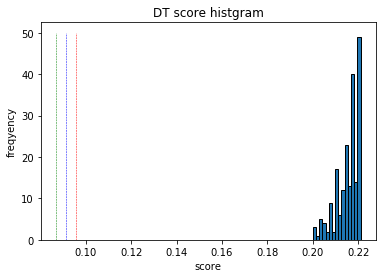

In [15]:
hist, bin_edges = np.histogram(score_list, bins=20)
plt.title('DT score histgram')
plt.xlabel('score')
plt.ylabel('freqyency')
plt.hist(score_list, bins=15, histtype='barstacked', ec='black')
# ε=1 に緑線
plt.vlines(base_score*1, 0, 50, "green", linestyle='dashed', linewidth=0.5)
# ε=1.05 に青い線
plt.vlines(base_score*1.05, 0, 50, "blue", linestyle='dashed', linewidth=0.5)
# ε=1.1 に赤い線
plt.vlines(base_score*1.1, 0, 50, "red", linestyle='dashed', linewidth=0.5)

## feature importance of gain importance

In [16]:
vic_list = VIC(X, y, rashomon_list, "gain")

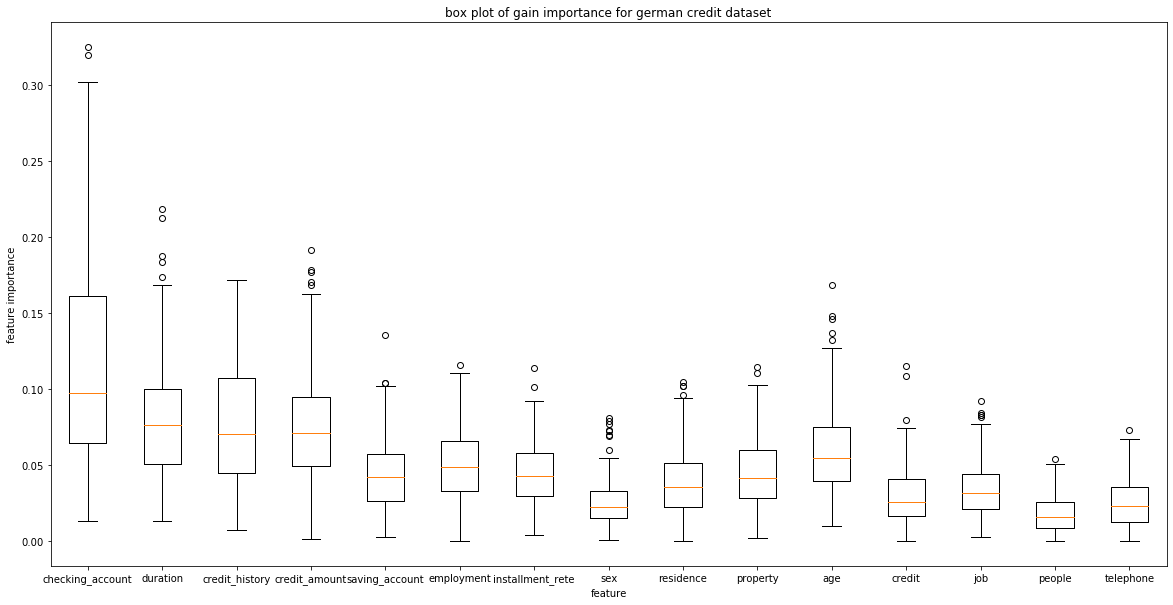

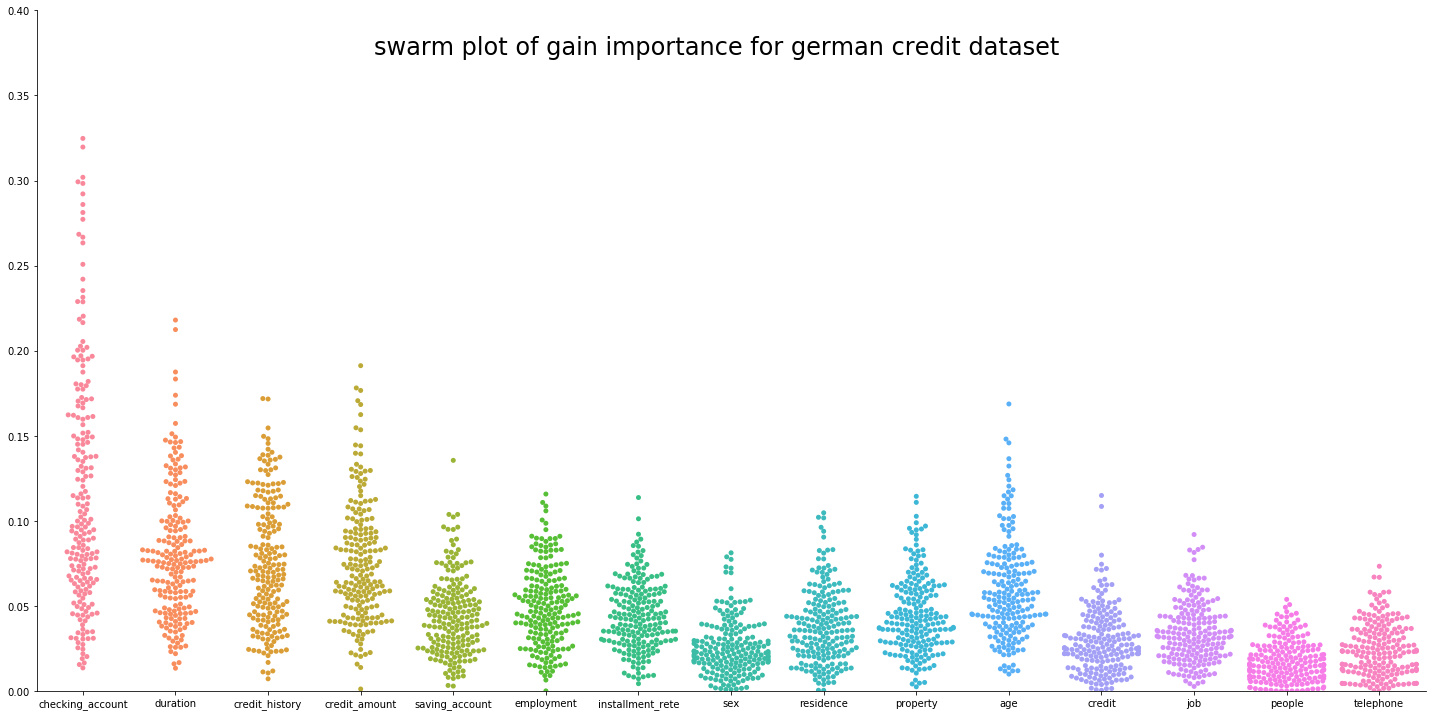

In [17]:
VIC_scatter_s(vic_list, 0, 15, "gain", list(X.columns))

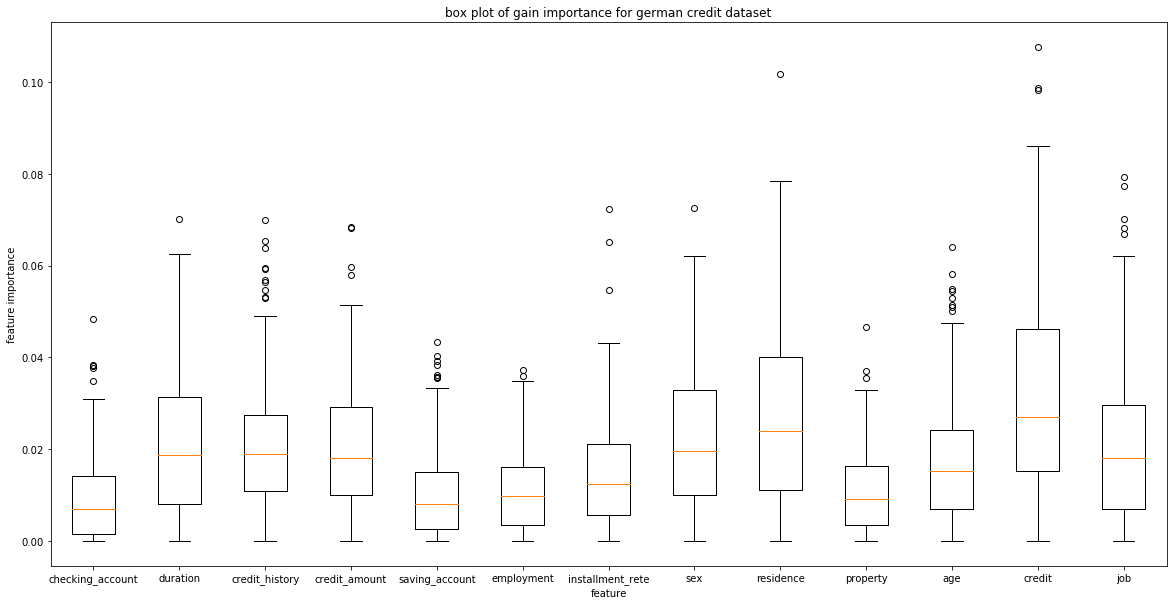

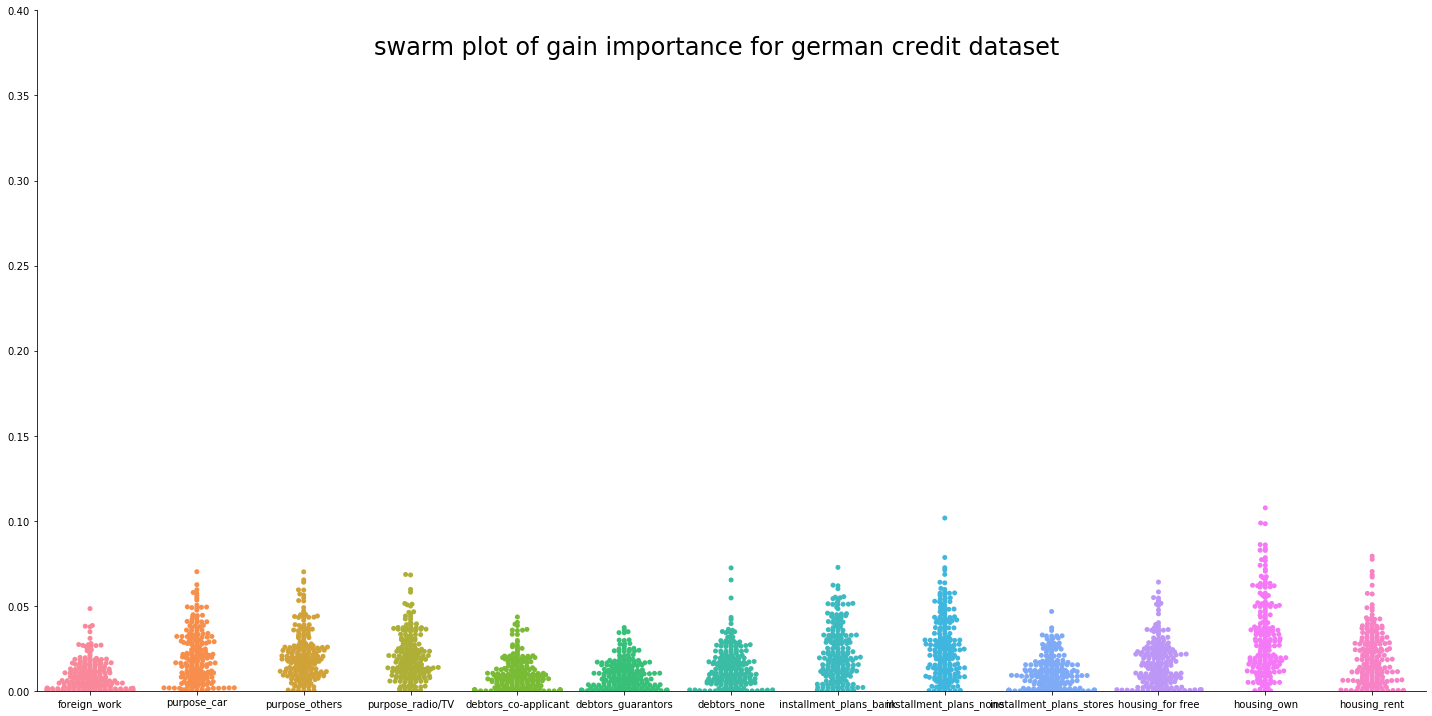

In [18]:
VIC_scatter_s(vic_list, 15, 29, "gain", list(X.columns))

## feature importance of permutation importance

In [19]:
vic_list2 = VIC(X, y, rashomon_list, "per")

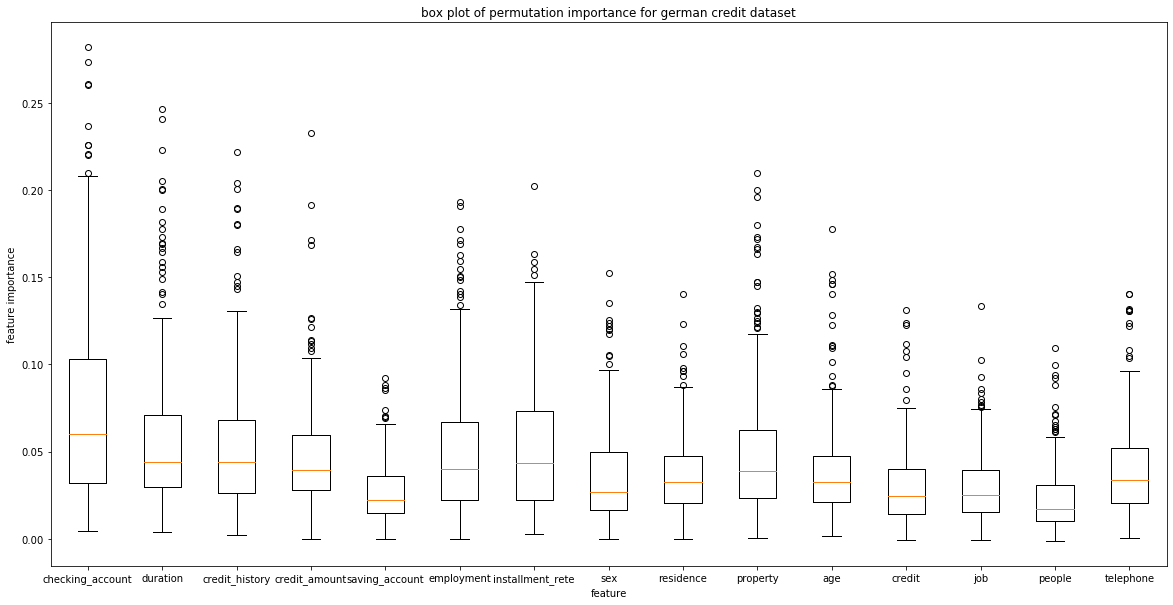

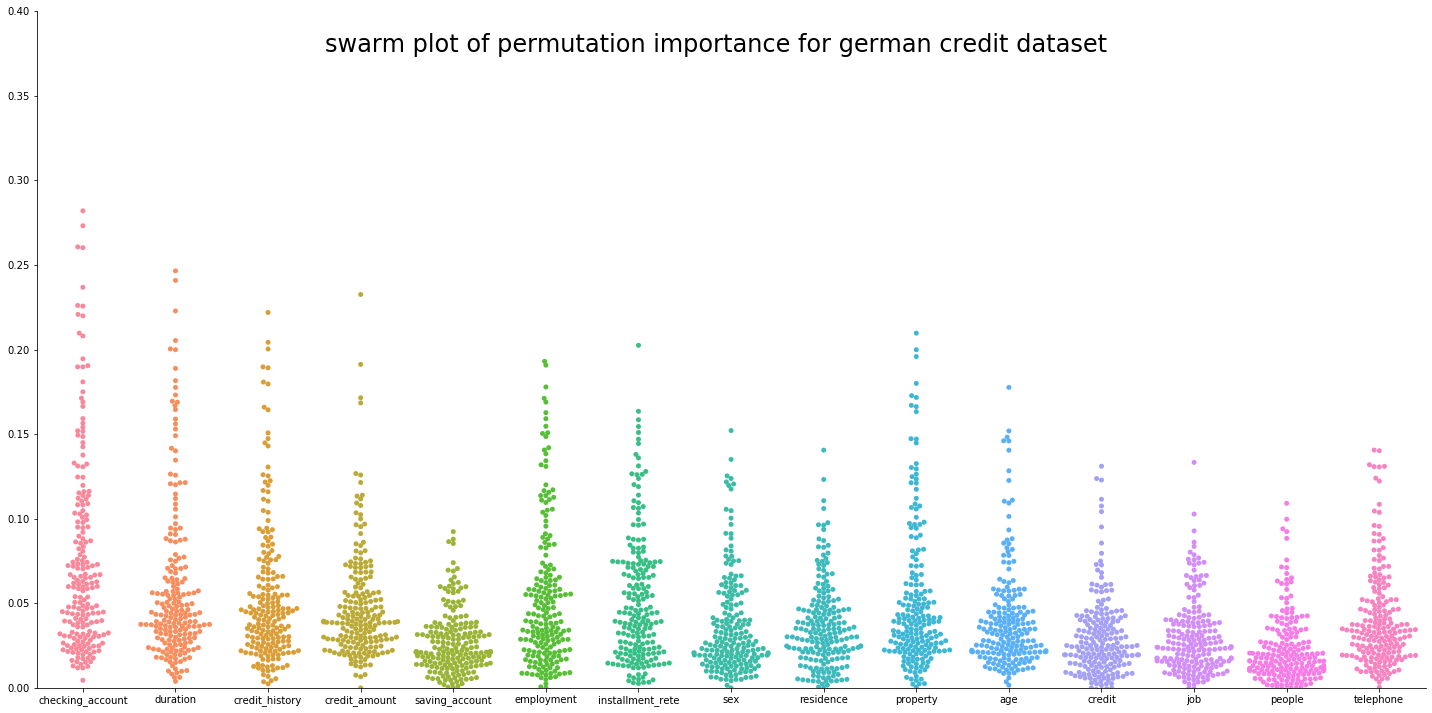

In [20]:
VIC_scatter_s(vic_list2, 0, 15, "permutation", list(X.columns))

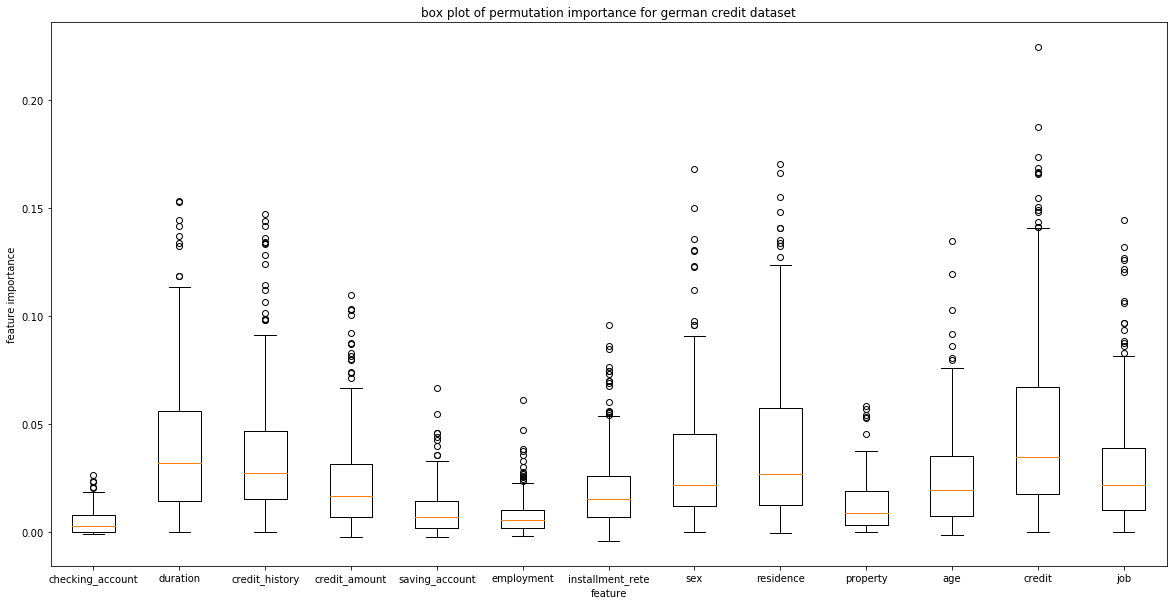

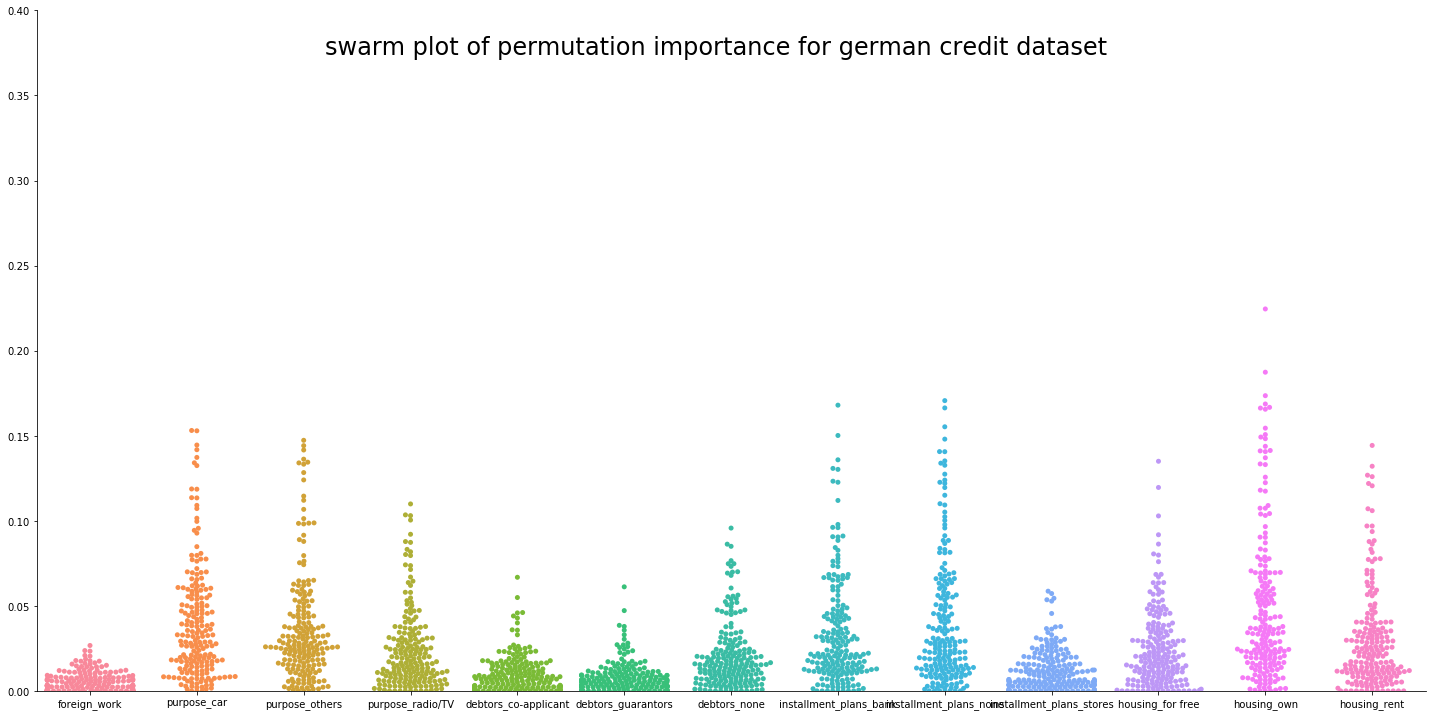

In [21]:
VIC_scatter_s(vic_list2, 15, 29, "permutation", list(X.columns))

## 残す特徴量
- checking account : Status of existing checking account
- duration : Duration in month
- credit_history : Credit history（滞納しているか）
- credit_amount : Credit amount
- employment : Present employment since
- installment_rate : Installment rate in percentage of disposable income
- property : Property(real estate, car etc..)
- age : Age
- (purpose : Purpose(car, radio/TV, others) )→削る
- (housing : Housing(rent, own, for free))→削る
- sex を入れる

In [11]:
drop_feature = ["saving_account", "employment", "debtors_co-applicant", "debtors_guarantors", 
                "debtors_none", "residence", "credit", "job", "people", "telephone", "foreign_work", "purpose_car", "purpose_radio/TV", 
                "purpose_others", "housing_rent", "housing_for free", "installment_plans_bank", "installment_plans_none", "installment_plans_stores"]
new_X = X.drop(drop_feature, axis=1)
new_X.head()

,checking_account,duration,credit_history,credit_amount,installment_rete,sex,property,age,housing_own
0,1,6,4,1169,4,0,0,67,1
1,2,48,2,5951,2,1,0,22,1
2,0,12,4,2096,2,0,0,49,1
3,1,42,2,7882,2,0,1,45,0
4,1,24,3,4870,3,0,4,53,0


In [12]:
base_dt2 = DecisionTreeClassifier(max_depth=9, random_state=0)
base_dt2.fit(new_X, y)
base_score2 = 1 - base_dt2.score(new_X, y)
print("base_score : " + str(base_score2))

base_score : 0.124


In [13]:
rt_dt_list2 = rf_(new_X, y, "depth", 9, 1000, 0)
et_dt_list2 = et_(new_X, y, "depth", 9, 1000, 0)
dt_list2 = rt_dt_list2 + et_dt_list2

In [14]:
rashomon_list2, score_list2 = rashomon_set(new_X, y, dt_list2, 100)

base_score : 0.124
max score : 0.19199999999999995
epsilon : 1.548387096774193


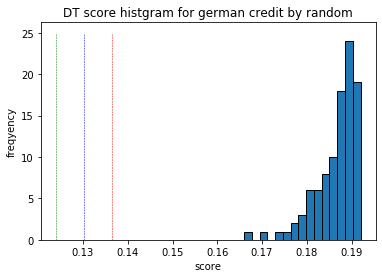

In [24]:
print("base_score : " + str(base_score2))
print("max score : " + str(max(score_list2)))
print("epsilon : " + str(max(score_list2)/base_score2))

hist, bin_edges = np.histogram(score_list2, bins=20)
plt.title('DT score histgram for german credit by random')
plt.xlabel('score')
plt.ylabel('freqyency')
plt.hist(score_list2, bins=15, histtype='barstacked', ec='black')
# ε=1 に緑線
plt.vlines(base_score2*1, 0, 25, "green", linestyle='dashed', linewidth=0.5)
# ε=1.05 に青い線
plt.vlines(base_score2*1.05, 0, 25, "blue", linestyle='dashed', linewidth=0.5)
# ε=1.1 に赤い線
plt.vlines(base_score2*1.1, 0, 25, "red", linestyle='dashed', linewidth=0.5)

In [17]:
new_vic_list = VIC(new_X, y, rashomon_list2, "gain")

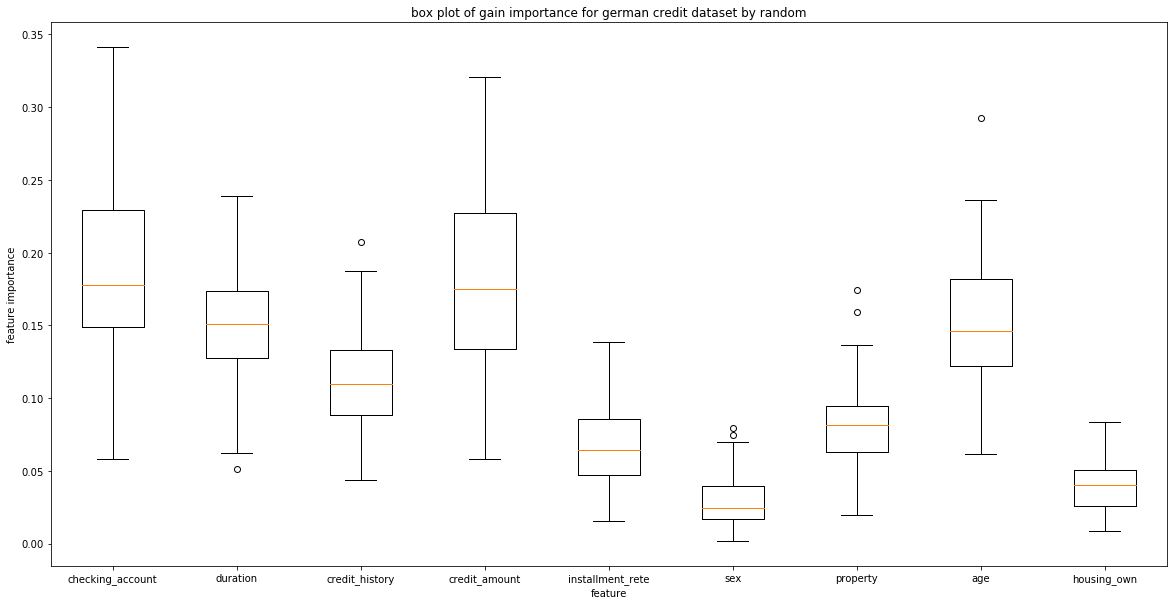

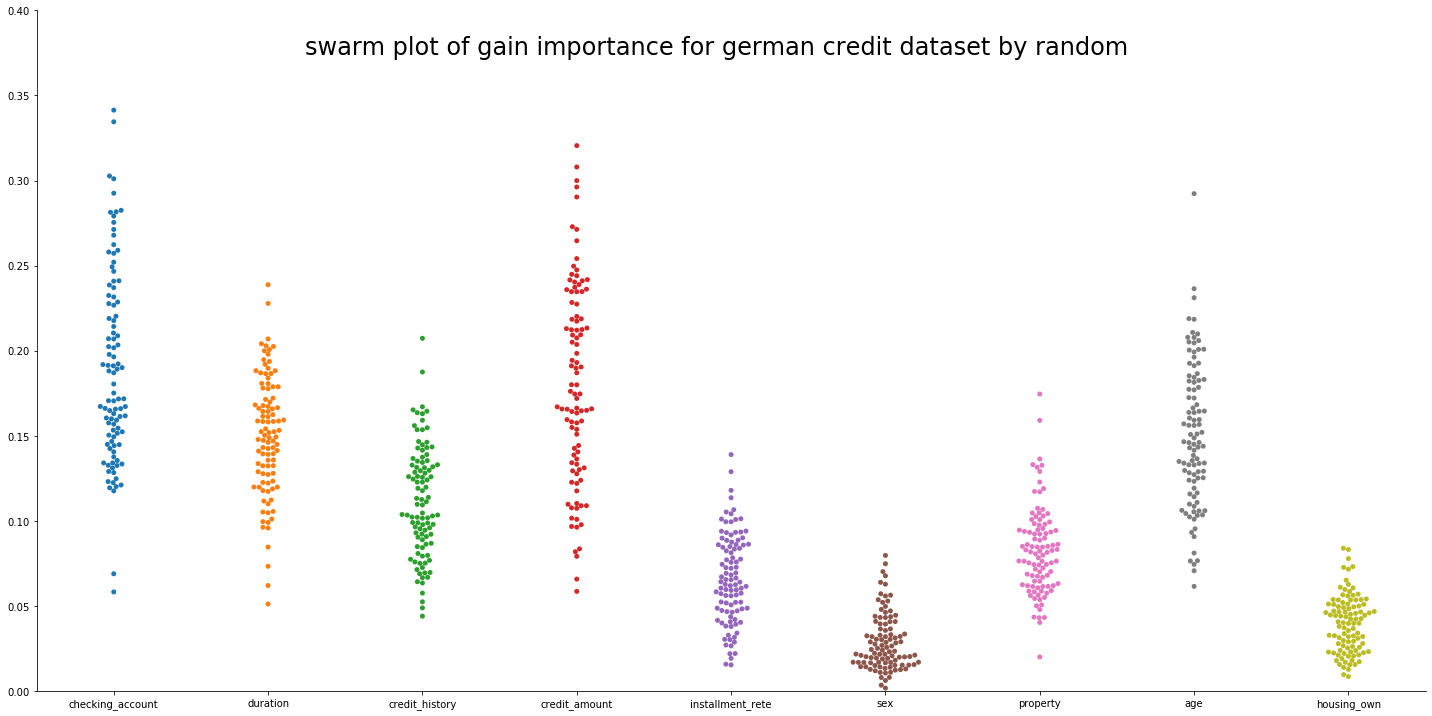

In [18]:
VIC_scatter(new_vic_list, "gain", list(new_X.columns))

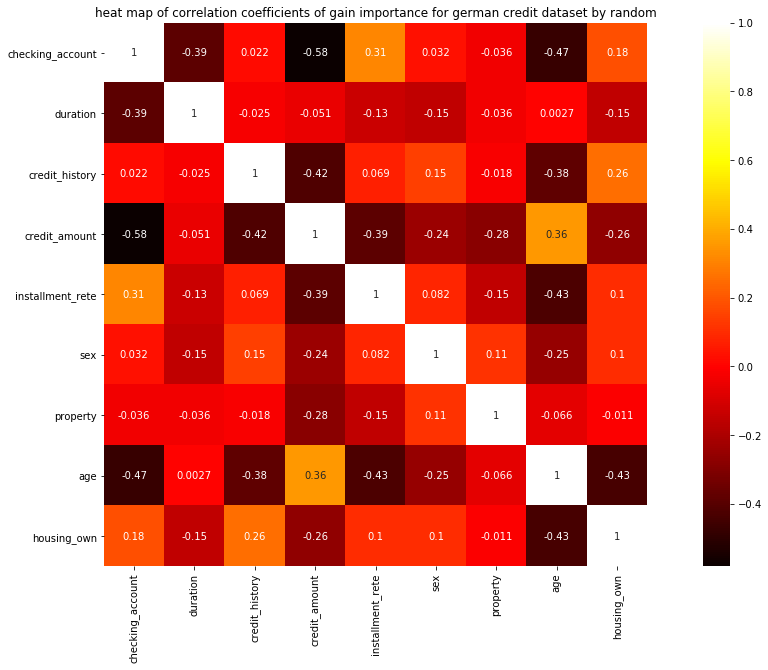

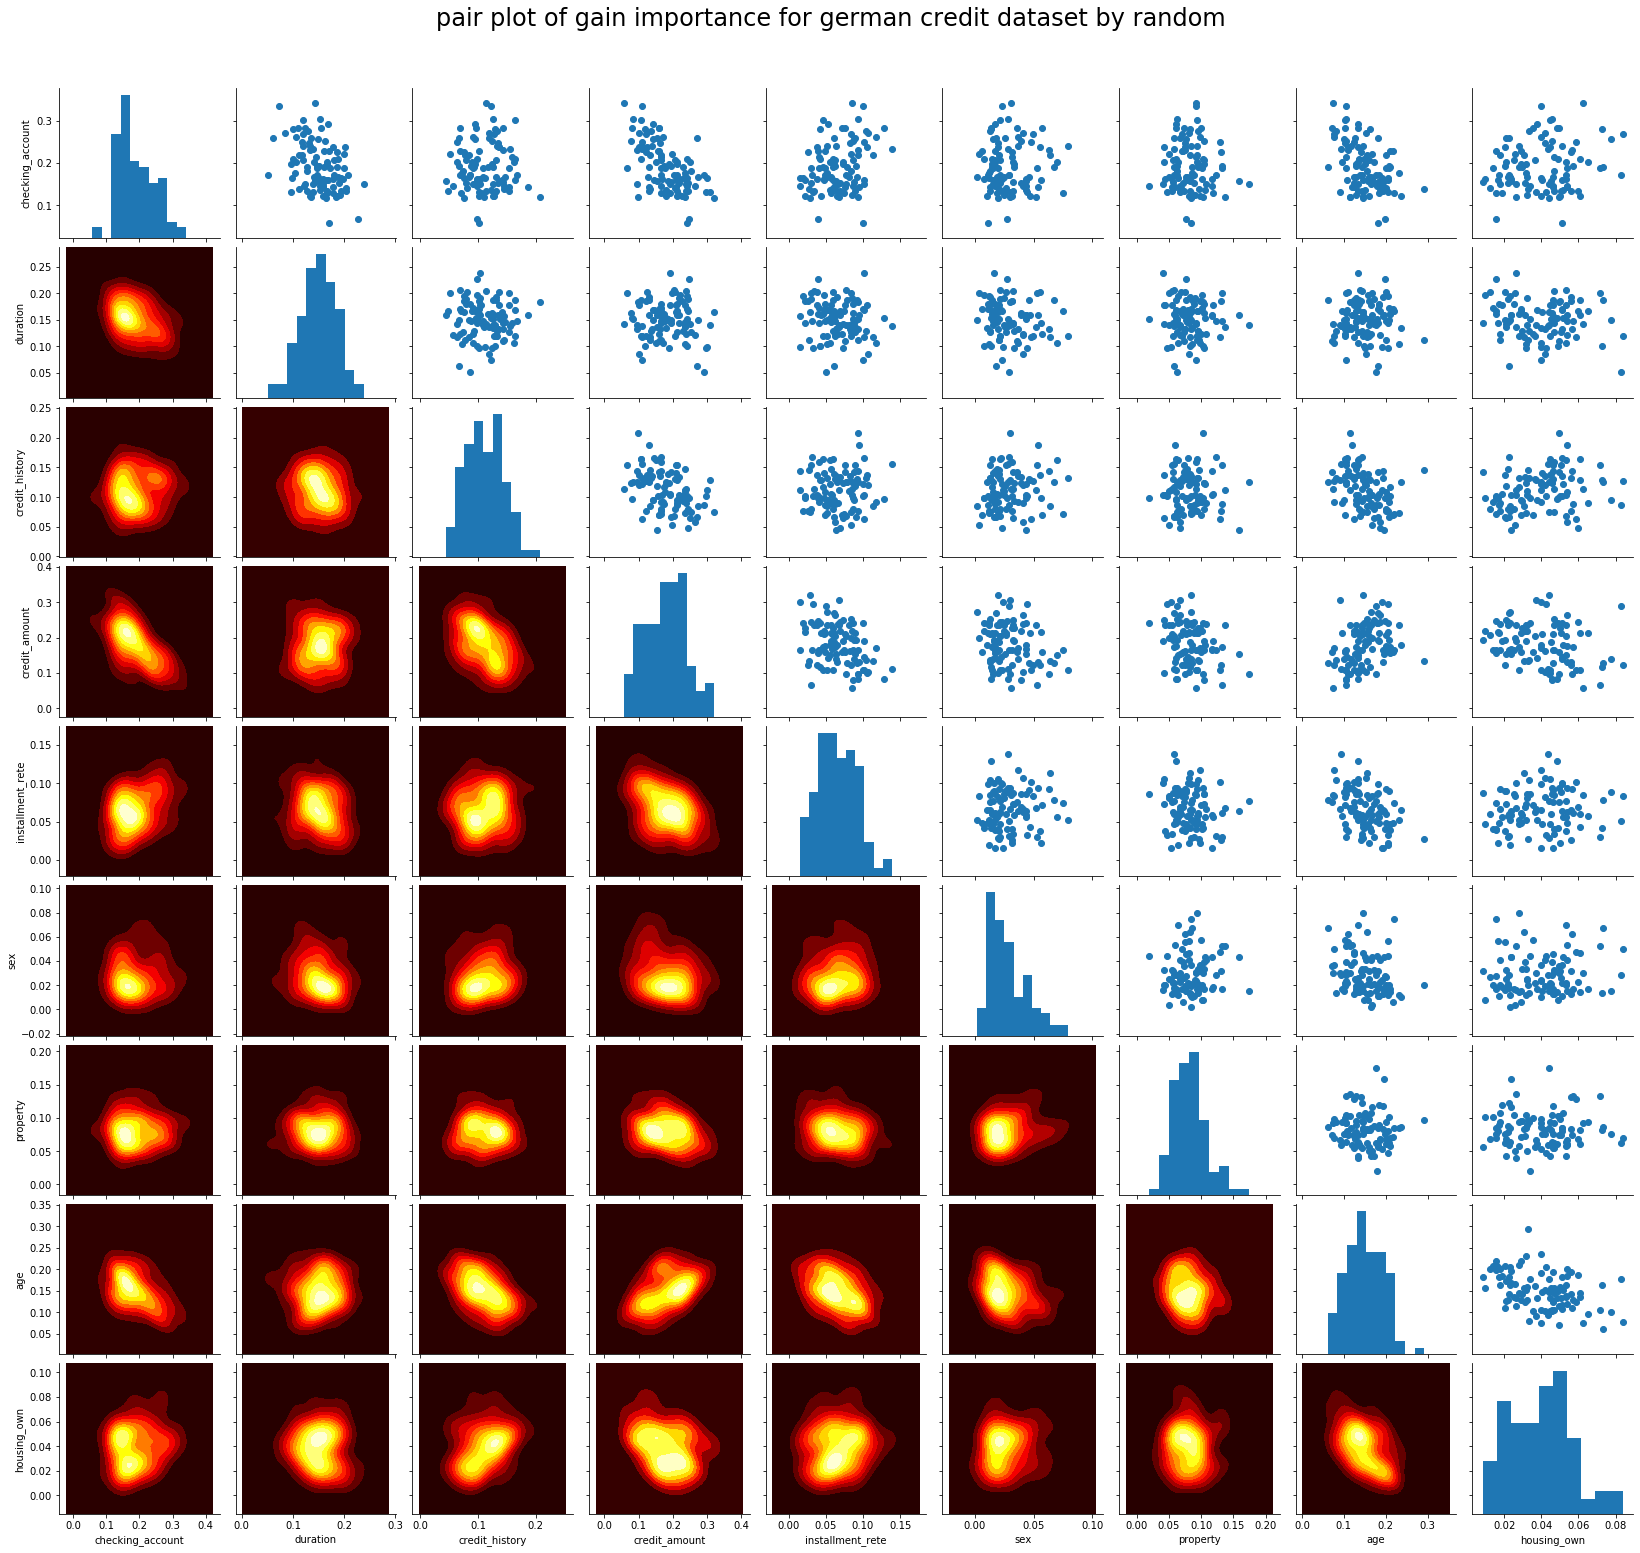

In [19]:
VIC_correlation(new_vic_list, "gain", list(new_X.columns))

In [20]:
new_vic_list2 = VIC(new_X, y, rashomon_list2, "per")

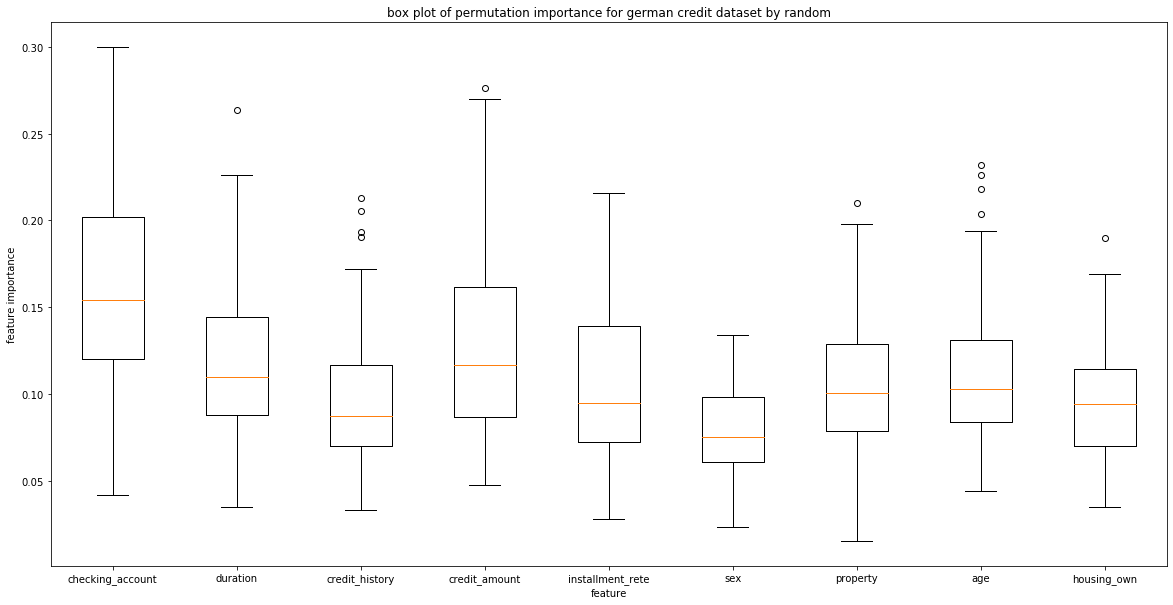

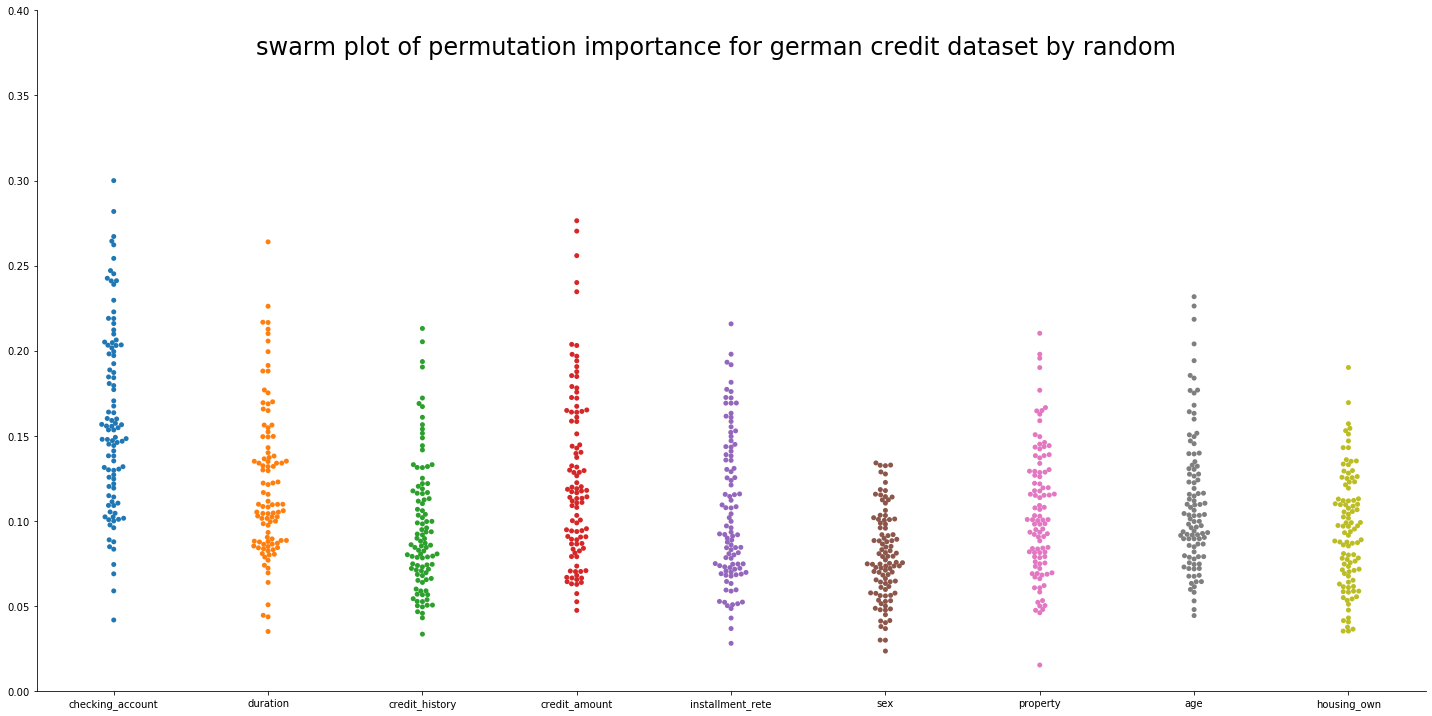

In [21]:
VIC_scatter(new_vic_list2, "permutation", list(new_X.columns))

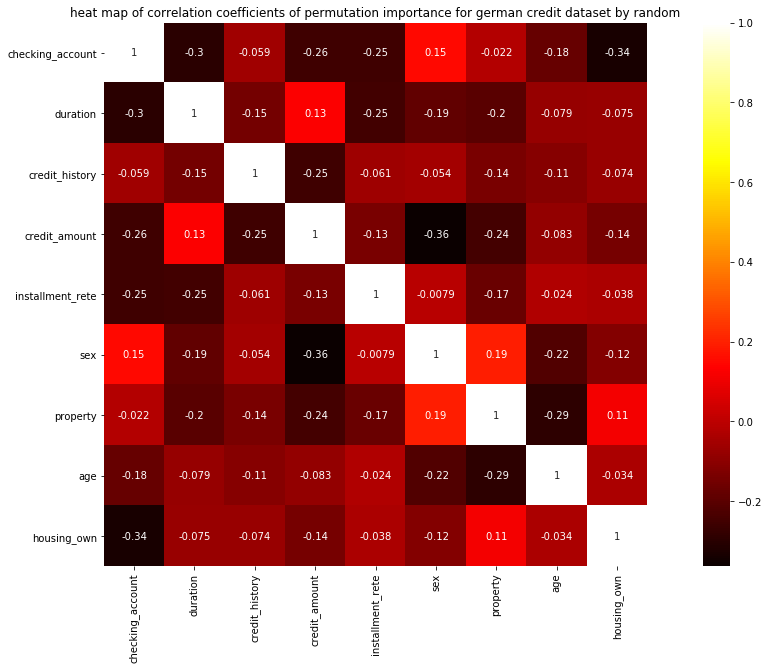

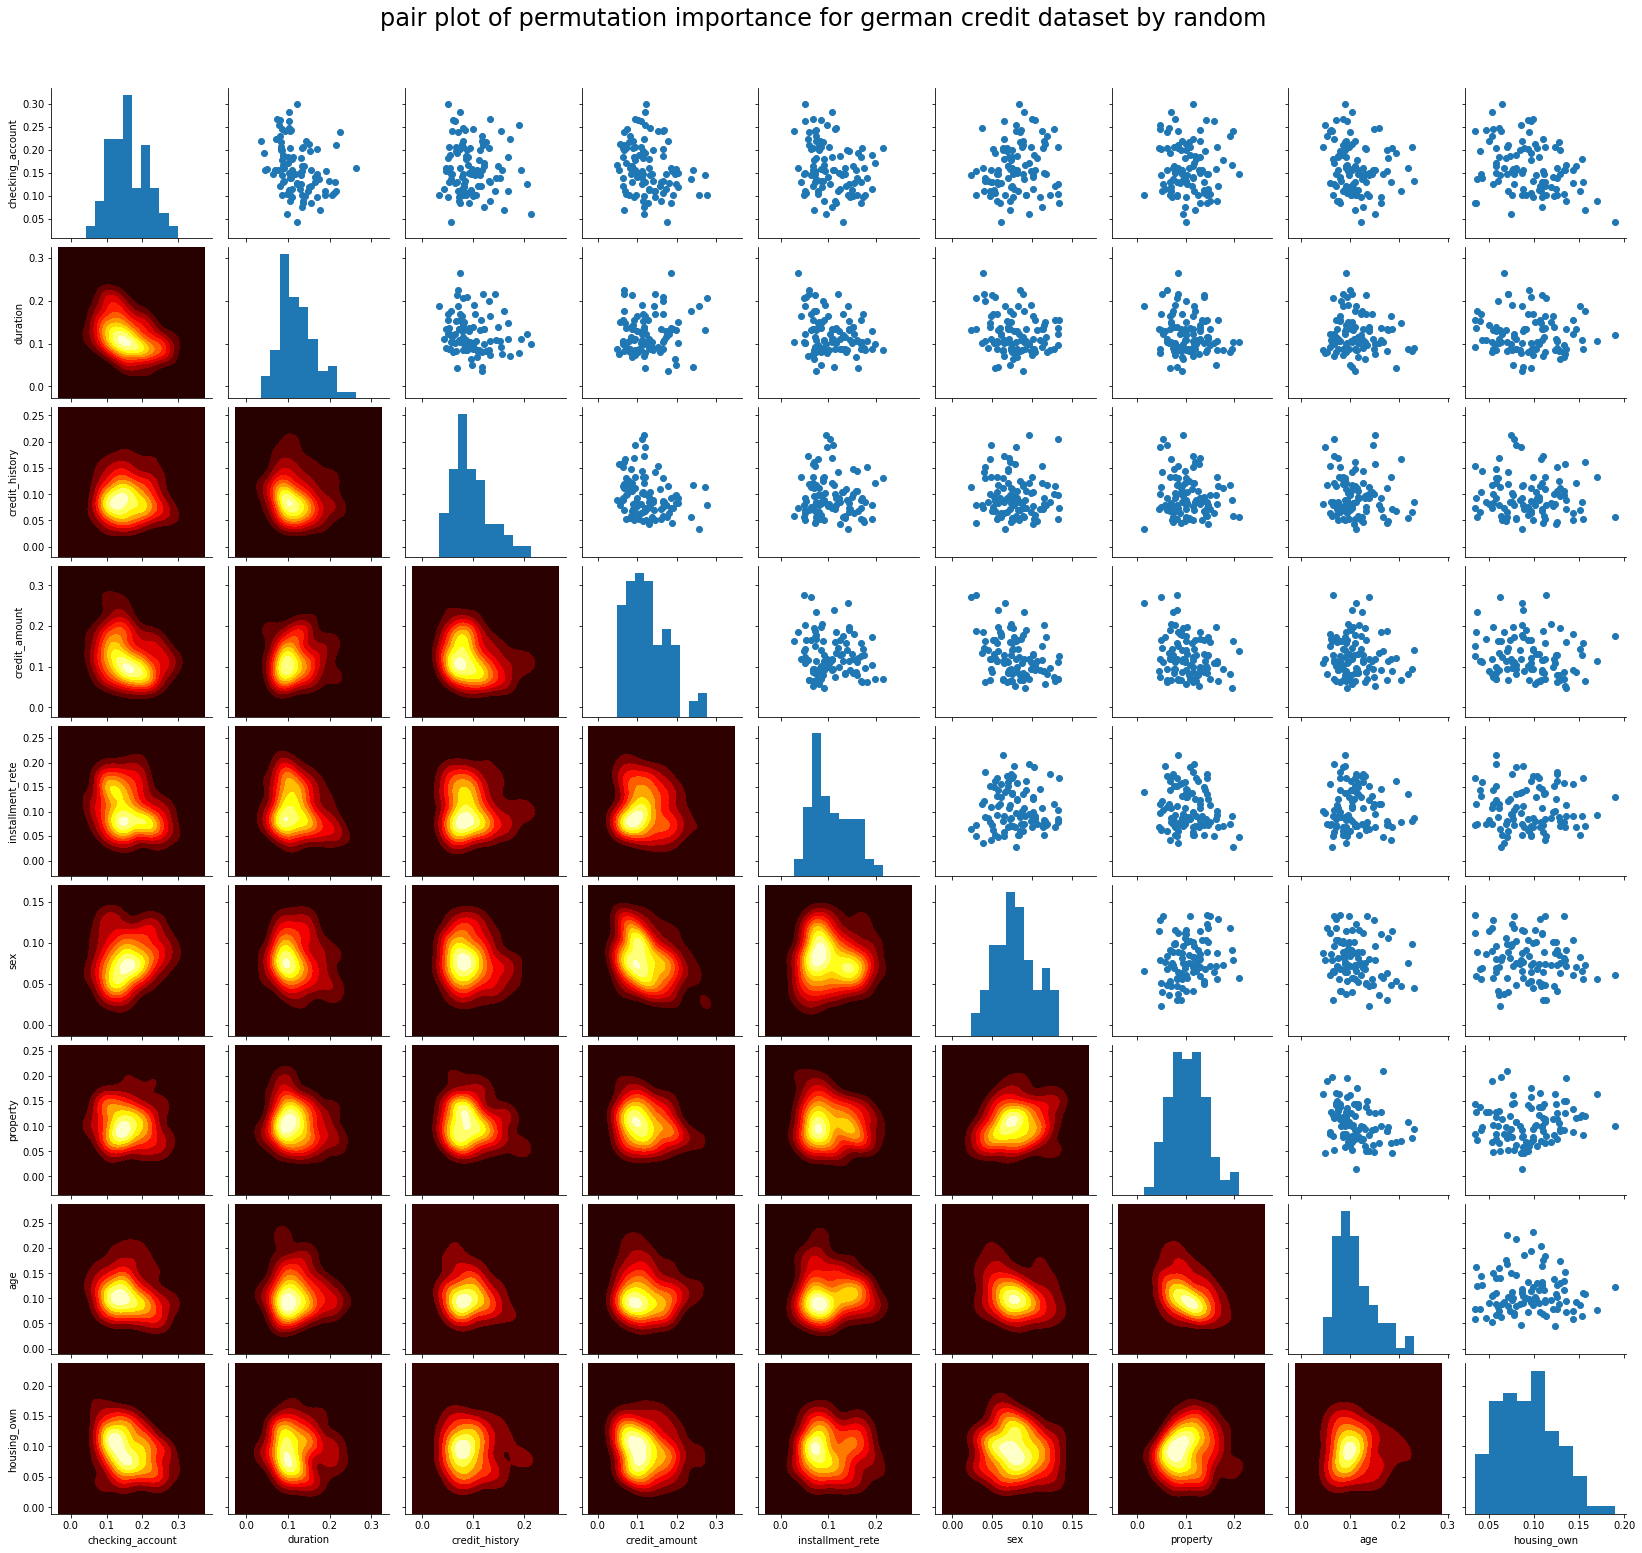

In [22]:
VIC_correlation(new_vic_list2, "permutation", list(new_X.columns))